In [79]:
# IMPORTS
import torch
import torch.nn as nn
import numpy as np
import PIL
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import torch.optim as optim
import torchvision
import cv2
from skimage.restoration import denoise_tv_bregman
from imageio import imwrite
from google.colab import drive
from torchvision.utils import save_image


In [80]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# AlexNet

In [82]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(    
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5),
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=5),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [127]:
octaves = [
        {
            'margin': 0,
            'window': 0.3, 
            'iter_n':190,
            'start_denoise_weight':0.4,
            'end_denoise_weight': 0.4,
            'start_step_size':1,
            'end_step_size':2
        },
        {
            'margin': 0,
            'window': 0.3,
            'scale':1.2,
            'iter_n':150, 
            'start_denoise_weight':0.01,
            'end_denoise_weight': 2,
            'start_step_size':1.,
            'end_step_size':1.
        },
        {
            'margin': 50,
            'window': 0.2,
            'scale': 1.0,
            'iter_n':20,
            'start_denoise_weight':0.1,
            'end_denoise_weight': 2,
            'start_step_size':2.,
            'end_step_size':2.
        },
        {
            'margin': 0,
            'window': 0.3, 
            'iter_n':10,
            'start_denoise_weight':0.4,
            'end_denoise_weight': 2,
            'start_step_size':2.0,
            'end_step_size':2.0
        }
    ]

In [84]:
class FeatureVisualizer:
  def __init__(self, model, loss_func):
    self.model = model
    self.loss_func = loss_func

  def _make_step(self, i, image, mean, std, step_size, denoise_weight, margin):
    image.requires_grad_()
    self.model.zero_grad()
    self.model(image)

    out, target_grad = self.loss_func()
    out.backward(target_grad, inputs=[image])

    g = image.grad.detach()
    if margin != 0:
      mask = torch.zeros_like(g)
      _, _, h, w = image.shape
      mask[:, :, 0 + margin: h - margin, 0 + margin: w - margin] = 1
      g *= mask

    g *= step_size/g.abs().mean() / std[:, None, None] / 255
    image = image.detach() + g
    image.clip_((0-mean[:, None, None]) / std[:, None, None], (1-mean[:, None, None]) / std[:, None, None])  # TODO: fixme
    asimg = (image * std[:, None, None] + mean[:, None, None])[0].permute(1, 2, 0).cpu().numpy().astype(np.float64) * 255
    denoised = denoise_tv_bregman(asimg, weight=denoise_weight, max_num_iter=100, eps=1e-3)
    return (torch.from_numpy(denoised).permute(2, 0, 1).float().to(device) / 255 - mean[:, None, None]) / std[:, None, None]
    
  def explain(self, image, mean, std, size=(3, 227, 227)):
    assert image.ndim == 3
    assert image.size(0) == 3
  
    _, h, w = image.shape
    image = image.clone()  
    iter = 0
    for octave_i, octave in enumerate(octaves):
        if 'scale' in octave:
          image = torch.tensor(nd.zoom(image.cpu(), (1, octave['scale'], octave['scale']))).to(device)
        _,imw,imh = image.shape
        
        for i in range(octave['iter_n']):
            if imw > w:
                mid_x = (imw-w)/2
                width_x = imw-w
                ox = np.random.normal(mid_x, width_x * octave['window'], 1)
                ox = int(np.clip(ox, 0, imw-w))
                mid_y = (imh-h)/2
                width_y = imh-h
                oy = np.random.normal(mid_y, width_y * octave['window'], 1)
                oy = int(np.clip(oy, 0, imh-h))
                image_crop = image[:, ox:ox+w, oy:oy+h]
            else:
                ox = 0
                oy = 0
                image_crop = image.clone()

            image_crop = image_crop.unsqueeze(0)            
            step_size = octave['start_step_size'] + ((octave['end_step_size'] - octave['start_step_size']) * i) / octave['iter_n']
            denoise_weight = octave['start_denoise_weight'] - (octave['start_denoise_weight'] - (octave['end_denoise_weight']) * i) / octave['iter_n']
            image_crop = self._make_step(iter, image_crop, mean, std, step_size, denoise_weight, octave['margin'])
            image[:,ox:ox+w,oy:oy+h] = image_crop

            iter += 1
            if iter % 50 == 0:
              print(f"iter: {iter}")    
    return image.cpu()

In [85]:
class LossFunc:
  def __init__(self, layer, channel, xy=[0, 0]) -> None:
    self.channel = channel
    self.xy = xy
    self.forward_hook = layer.register_forward_hook(self._hook_fn)
    self.loss = None

  def _hook_fn(self, module, input, output):
    target_grad = torch.zeros_like(output)
    assert target_grad.size(0) == 1
    if output.ndim == 2:
      target_grad[:, self.channel] = 1
    elif output.ndim == 4:
      target_grad[:, self.channel, self.xy[0], self.xy[1]] = 1
    else:
      raise RuntimeError("Invalid layer type!")
    self.loss = (output, target_grad)

  def __call__(self):
    if self.loss is None:
      raise RuntimeError("Hook was not called!")
    _loss = self.loss
    self.loss = None
    return _loss
    
  def close(self):
    self.hook.remove()

In [86]:
def visualize_image(image_path, mean, std, preprocess_steps, FV):  
  print(f"visualization starting from {image_path[:-4]} image:")
  
  input_image = preprocess_steps(PIL.Image.open(image_path)).to(device)
  output = FV.explain(input_image, mean, std)

  image = std[:, None, None].cpu() * output + mean[:, None, None].cpu()
  image = torch.clip(image, 0, 1)
  save_image(image, 'image.png')

  plt.imshow((image * 255).round().int().permute(1, 2, 0))
  plt.show()
  return output

In [108]:
channel = 498

model = AlexNet().to(device)
model.load_state_dict(torch.load("drive/MyDrive/net.pt"))
model.eval()

loss_func = LossFunc(model.classifier[-1], channel)
FV = FeatureVisualizer(model, loss_func)

visualization starting from mean_2 image:
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350


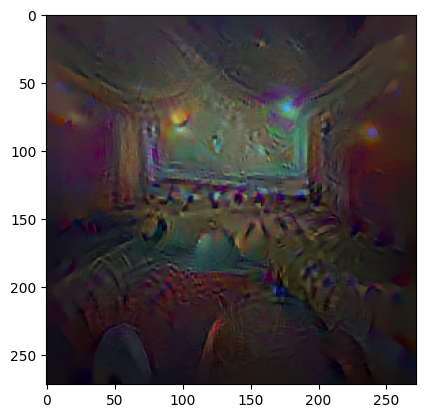

In [88]:
mean = (torch.tensor([123., 117., 104.])/255).to(device)
std = (torch.tensor([1., 1., 1.])).to(device)
preprocess_steps = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

res = visualize_image("mean_2.jpg", mean, std, preprocess_steps, FV)

# VGG

In [98]:
model = torchvision.models.vgg16(weights='DEFAULT').to(device).eval() 
loss_func = LossFunc(model.classifier[-1], channel)
FV = FeatureVisualizer(model, loss_func)

visualization starting from mean_2 image:
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350


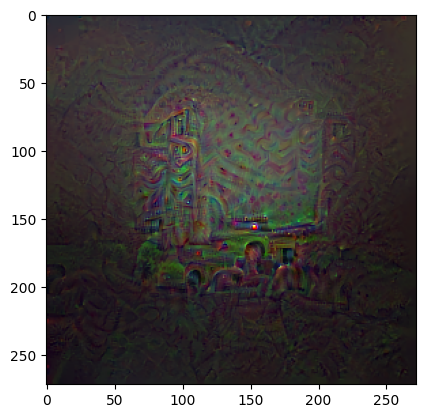

In [99]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)
preprocess_steps = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
res = visualize_image("mean_2.jpg", mean, std, preprocess_steps, FV)

# AlexNet Original

In [92]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='DEFAULT').to(device).eval()
loss_func = LossFunc(model.classifier[-1], channel)
FV = FeatureVisualizer(model, loss_func)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 246MB/s]


visualization starting from mean_2 image:
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350


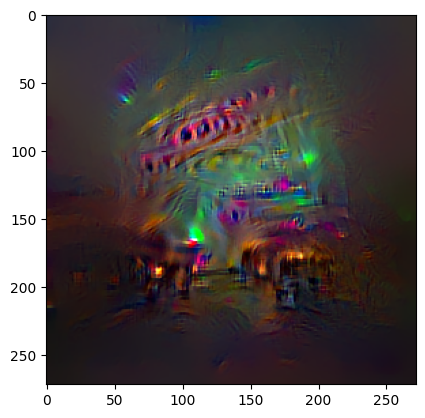

In [93]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)
preprocess_steps = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
res = visualize_image("mean_2.jpg", mean, std, preprocess_steps, FV)

# GoogleNet

In [101]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', weights='DEFAULT').to(device).eval()
loss_func = LossFunc(model.fc, channel)
FV = FeatureVisualizer(model, loss_func)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


visualization starting from mean_2 image:
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350


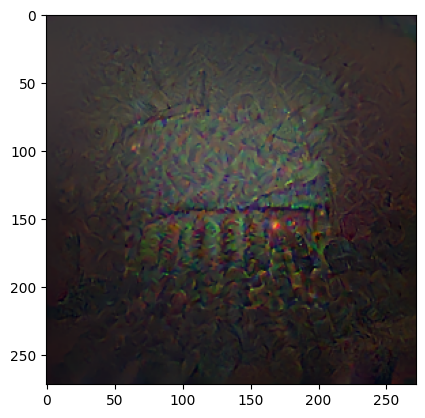

In [102]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)
preprocess_steps = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
res = visualize_image("mean_2.jpg", mean, std, preprocess_steps, FV)

# SqueezeNet

In [126]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', weights='DEFAULT').to(device).eval()
loss_func = LossFunc(model.classifier[-1], channel)
FV = FeatureVisualizer(model, loss_func)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


visualization starting from mean_2 image:
iter: 50
iter: 100
iter: 150
iter: 200
iter: 250
iter: 300
iter: 350


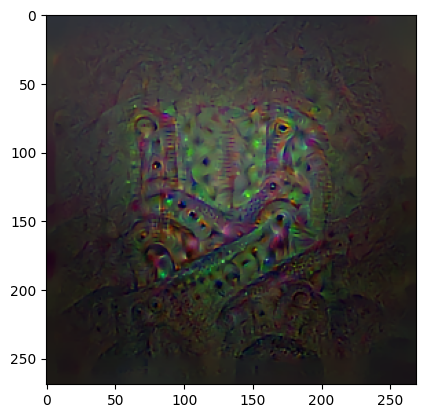

In [128]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)
preprocess_steps = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])
res = visualize_image("mean_2.jpg", mean, std, preprocess_steps, FV)

## Additional octave's version for modern neural networks

In [122]:
octaves = [
        {
            'margin': 0,
            'window': 0.3, 
            'iter_n':190,
            'start_denoise_weight':0.4,
            'end_denoise_weight': 0.4,
            'start_step_size':1,
            'end_step_size':2
        },
        {
            'margin': 0,
            'window': 0.3,
            'scale': 1.2,
            'iter_n':150, 
            'start_denoise_weight':0.01,
            'end_denoise_weight': 2,
            'start_step_size':1.,
            'end_step_size':1.
        },
        {
            'margin': 0,
            'window': 0.3,
            'scale':1.1/1.2,
            'iter_n':150, 
            'start_denoise_weight':0.01,
            'end_denoise_weight': 2,
            'start_step_size':1.,
            'end_step_size':1.
        },
        {
            'margin': 0,
            'window': 0.3,
            'scale':1.2/1.1,
            'iter_n':150, 
            'start_denoise_weight':0.01,
            'end_denoise_weight': 2,
            'start_step_size':1.,
            'end_step_size':1.
        },
        {
            'margin': 50,
            'window': 0.2,
            'scale': 1.0,
            'iter_n':20,
            'start_denoise_weight':0.1,
            'end_denoise_weight': 2,
            'start_step_size':2.,
            'end_step_size':2.
        },
        {
            'margin': 0,
            'window': 0.3, 
            'iter_n':10,
            'start_denoise_weight':0.4,
            'end_denoise_weight': 2,
            'start_step_size':2.0,
            'end_step_size':2.0
        }
    ]